# Deep Learning -BiLSTM

In [18]:
import os
import pandas as pd
import re
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from gensim.models import KeyedVectors
from gensim.downloader import load as gensim_load
from sklearn.metrics import confusion_matrix, classification_report
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaiki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaiki\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
# Load the dataset
df = pd.read_csv("D2.csv")

In [20]:
# Drop the unnecessary column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

In [21]:
# Drop rows with missing values
df.dropna(inplace=True)
print("\nShape after dropping missing values:", df.shape)


Shape after dropping missing values: (10391, 3)


In [22]:
# Check the distribution of 'status' before resampling
print("\nStatus Value Counts before resampling:")
print(df['status'].value_counts())



Status Value Counts before resampling:
status
neutral          4374
negative         4112
very negative    1155
positive          750
Name: count, dtype: int64


In [23]:
#  Resampling to Balance Classes
def resample_data(df):
    max_count = df['status'].value_counts().max()
    df_resampled = pd.DataFrame()
    for status in df['status'].unique():
        df_class = df[df['status'] == status]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])
    return df_resampled

df = resample_data(df)
print("Value counts after resampling:")
print(df['status'].value_counts())

Value counts after resampling:
status
negative         4374
neutral          4374
positive         4374
very negative    4374
Name: count, dtype: int64


In [24]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['posts'] = df['posts'].apply(preprocess_text)
print("\nSample preprocessed text:")
print(df['posts'].head())


Sample preprocessed text:
2389    morning hen get bad news aunt cancer spread li...
9588    lose good friend terrible thing call lung canc...
7761    dad 58 cancer leg reach lung dad neglect cance...
1253    mom get throat cancer 6 monthe ago 6 monthe ag...
8703    title say 18 year old terrify colon cancer alr...
Name: posts, dtype: object


In [25]:
# Splitting Data and Encoding Labels
X = df['posts'].values
y = df['status'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (13996,) (13996, 4)
Testing set shape: (3500,) (3500, 4)


In [26]:
# Tokenization and Padding
max_words = 50000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_sequence_length = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')
print("Padded Training Data Shape:", X_train_padded.shape)
print("Padded Testing Data Shape:", X_test_padded.shape)

Padded Training Data Shape: (13996, 100)
Padded Testing Data Shape: (3500, 100)


In [27]:
# Loading Pre-trained Word2Vec via Gensim Downloader
print("Downloading the pre-trained Google News Word2Vec model. This may take a while...")
word2vec_model = gensim_load("word2vec-google-news-300")
embedding_dim = word2vec_model.vector_size  
print("Download complete. Embedding dimension:", embedding_dim)

Download complete. Embedding dimension: 300


In [28]:
# Building the Embedding Matrix with Fine-Tuning Enabled
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
found_count = 0

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
        found_count += 1
    else:
        # Initialize missing words with random vectors
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

print(f"Found embeddings for {found_count} out of {num_words} words.")

Found embeddings for 20006 out of 32979 words.


In [29]:
# Building the BiLSTM Model (with Fine-Tuning)
lstm_units = 64
num_classes = y_categorical.shape[1]

model = Sequential([
    Embedding(input_dim=num_words, 
              output_dim=embedding_dim, 
              input_length=max_sequence_length,
              weights=[embedding_matrix],
              trainable=True),  # Now set to True for fine-tuning
    Bidirectional(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\kaiki\Documents\anaconda\envs\tensorflow_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       9,893,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,893,700 (37.74 MB)

 Trainable params: 9,893,700 (37.74 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Training the Model
history = model.fit(X_train_padded, y_train,
                    epochs=10,           
                    batch_size=128,      
                    validation_data=(X_test_padded, y_test))

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 36s 287ms/step - accuracy: 0.4270 - loss: 1.2238 - val_accuracy: 0.7080 - val_loss: 0.7300
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 270ms/step - accuracy: 0.7199 - loss: 0.7204 - val_accuracy: 0.7851 - val_loss: 0.5752
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - accuracy: 0.7970 - loss: 0.5375 - val_accuracy: 0.8234 - val_loss: 0.4573
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 241ms/step - accuracy: 0.8649 - loss: 0.3862 - val_accuracy: 0.8551 - val_loss: 0.3942
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 242ms/step - accuracy: 0.8995 - loss: 0.2885 - val_accuracy: 0.8809 - val_loss: 0.3369
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - accuracy: 0.9276 - loss: 0.2235 - val_accuracy: 0.8926 - val_loss: 0.3075
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 27s 246ms/step - accuracy: 0.9405 - loss: 0.1840 - val_accuracy: 0.8969 - val_loss: 0.3193
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 30s 274ms/step - accuracy: 0.9609 - loss: 0

In [31]:
# Evaluating the Model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("\nTest Accuracy: {:.2f}%".format(test_accuracy * 100))


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9108 - loss: 0.3356

Test Accuracy: 90.91%


110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Confusion Matrix:
[[733  95  21  24]
 [119 718  33   4]
 [  1   0 901   2]
 [ 19   0   0 830]]


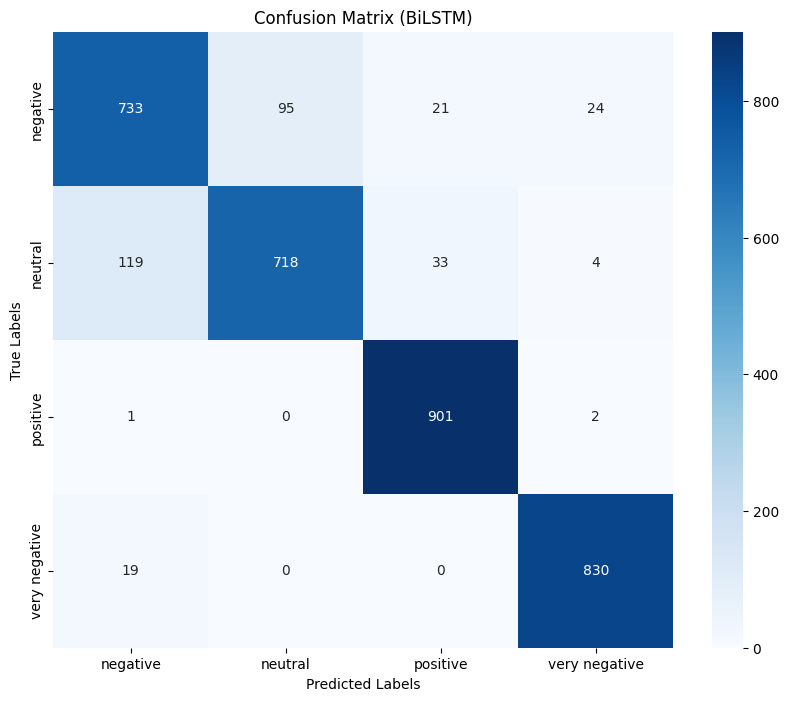

Classification Report:
               precision    recall  f1-score   support

     negative     0.8406    0.8396    0.8401       873
      neutral     0.8831    0.8215    0.8512       874
     positive     0.9435    0.9967    0.9693       904
very negative     0.9651    0.9776    0.9713       849

     accuracy                         0.9091      3500
    macro avg     0.9081    0.9089    0.9080      3500
 weighted avg     0.9080    0.9091    0.9081      3500



In [38]:
# Generating Predictions and Evaluation Metrics
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BiLSTM)')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

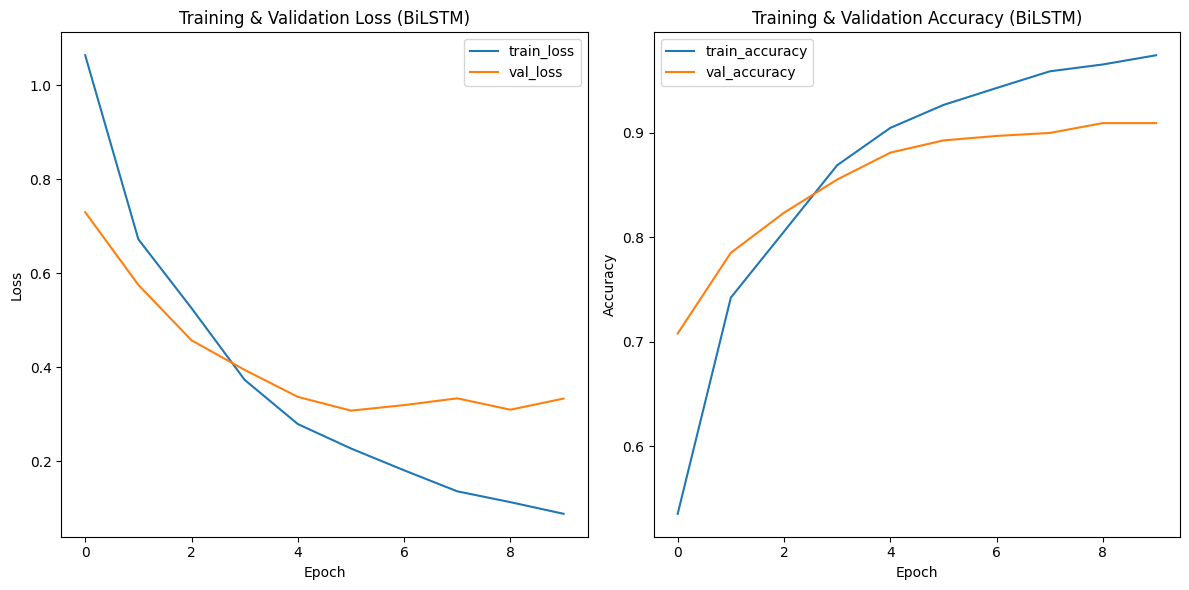

In [33]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training & Validation Loss (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training & Validation Accuracy (BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

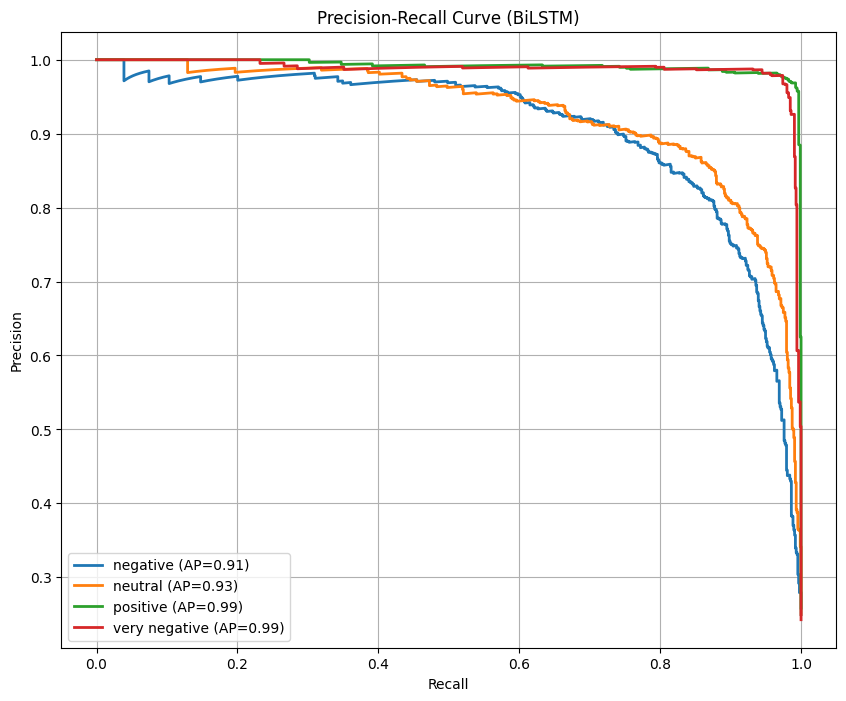

In [36]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize true labels for multi-class PR curve
y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))
precision = dict()
recall = dict()
avg_precision = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'{label_encoder.classes_[i]} (AP={avg_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (BiLSTM)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


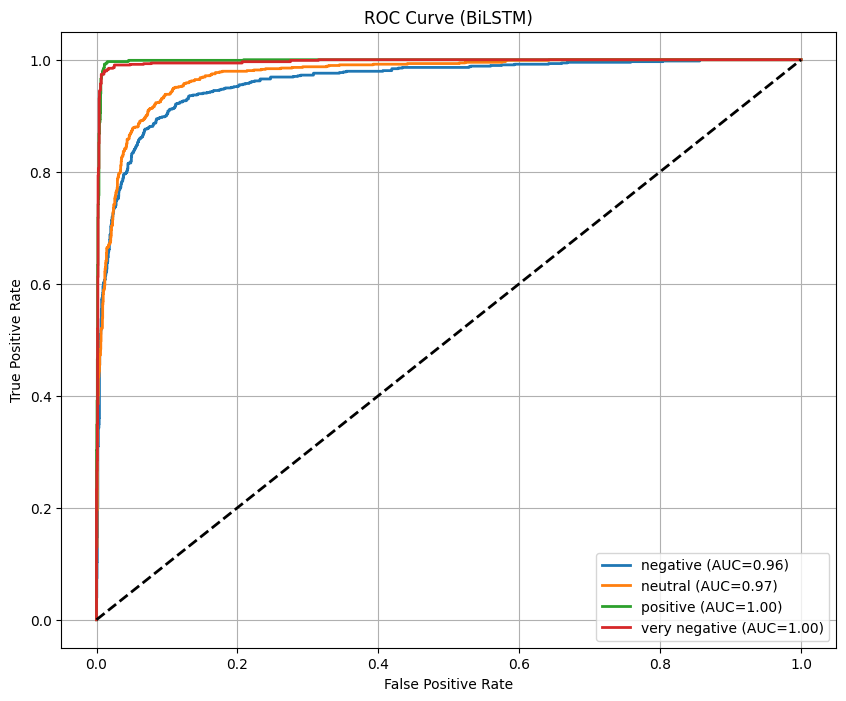

In [37]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label_encoder.classes_[i]} (AUC={roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (BiLSTM)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

